# Projet final du Kit Big Data 2022  - MS IA 
# YIBOE Ossee

Le projet final du Kit Big Data 2022 porte sur les données du Vendée Globe 2020-2021.

Le projet se déroule 24 novembre au 4 décembre 2022 date limite pour rendre vos projets respectifs.

Les données du dernier Vendée Globe sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

Le rendu sera un notebook Jupyter fourni aux formats ipynb et HTML.

##*Barème sur 15 points :*

- Acquisition et chargement des données : 3 points

- Préparation des données : 5 points

- Analyses et story telling : 7 points

# Exemples de traitements et d'analyses :

## Acquisition et chargement des données :
Acquérir l'ensemble des fichiers Excel des classements via la page de classement.
Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
Acquérir les caractéristiques des bateaux.

## Préparation des données

Préparation des données relatives aux classements.
Extraction des caractéristiques techniques de chacun des voiliers.
Rapprochement des données des voiliers avec celle des classements.


## Analyses et story telling
Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
Visualisation de la distance parcourue par voilier.
Cartes avec les routes d'un ou plusieurs voiliers.
Analyses de séries temporelles.
Application d'algorithmes statistiques ou de machine learning.
etc.

# Sources des données

Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement

Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire

Site web donnant accès à des fichiers avec les formes géométriques des côtes : https://www.naturalearthdata.com/ 
(ou bien utilisez les librairies plotly ou ipyleaflet pour produire des cartes)
etc.

# **Compte rendu**

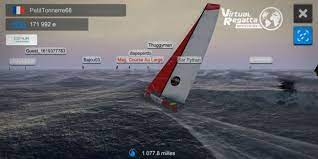

## **Importation et Installation**

In [1270]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import os
import uuid
import xlwings as xw
import requests
import re
from bs4 import BeautifulSoup
from urllib.parse import  urljoin # python2 -> from urlparse import urljoin 
from shutil import copyfileobj
from urllib import request
import os
from pathlib2 import Path
import uuid
from lat_lon_parser import parse
import plotly.graph_objects as go
from plotly.offline import plot
import geopandas
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

# **Acquisition et chargement des données** 

- Acquérir l'ensemble des fichiers Excel des classements via la page de classement.
- Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
- Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
- Acquérir les caractéristiques des bateaux.

## **Chargement des données de classements et sauvegarde en local**

In [1321]:
# Extraction des noms de fichiers depuis la page web

def chargement_class_date(base) :
    base = "https://www.vendeeglobe.org/fr/classement"
    res = requests.get(base)
    liste=[]

    soup = BeautifulSoup(res.text, "html.parser") 
    soup = soup.find_all(class_="form__input m--select onsubmit-rank")
    res = []

    pattern = re.compile(r'([0-9:\s-]+)</option>')
    for element in soup : 
        for e in re.findall(pattern, str(element)):
            v = e.replace(' ','_').replace(':','').replace('-','')[1:]
            res.append(v)




In [1322]:
## Chargement des données de classements


def chargement_données(res) :
    for suite in res :
        filename = 'vendeeglobe_'+ suite + '.xlsx'

        url = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'
        url = url + str(filename) 
        with request.urlopen(url) as response, open(NAKED_PATH + filename, 'wb' ) as outfile: 
            copyfileobj(response, outfile)


In [1323]:
## Chargement des données de classement

base = "https://www.vendeeglobe.org/fr/classement"

## Enregistrement des données en local

res = chargement_class_date(base)    
#chargement_données(res)

## **Chargement des caractéristiques des bateaux**

In [1324]:
# Caractéristiques des bateaux

NAKED_PATH ='/Users/jojo/Documents/MS IA/Kit Big Dta/'
os.chdir(NAKED_PATH)

base = 'https://www.vendeeglobe.org/fr/glossaire'
res = requests.get(base)
liste=[]

def details_boats(liste, res):

    soup = BeautifulSoup(res.text, "html.parser") 
    boats = soup.find_all('div',class_="boats-list__popup-infos")
    boat_name = [ element.find("h3").text for element in boats]
    skippers = [ element.find("span").text.strip() for element in soup.find_all('div',class_="boats-list__infos")]
    details = [ element.find_all("li") for element in soup.find_all('div',class_="boats-list__popup-infos") ]

    soup = soup.find_all('div',class_="boats-list__popup-infos")
    res = []

    for index ,s in (enumerate(soup)) :
        temp  = s.find_all('li')
        details = [ tuple(element.text.split(":", maxsplit=1))[::-1] for element in temp ]
        dico_boat = dict(skipper = skippers[index],b_name = boat_name[index])
        dico_boat.update(dict(map(reversed,details)))

        liste.append(dico_boat)
    
    return liste

df = details_boats(liste, res)

In [1326]:
NAKED_PATH ='/Users/jojo/Documents/MS IA/Kit Big Dta/'
os.chdir(NAKED_PATH)

base = 'https://www.vendeeglobe.org/fr/glossaire'

res = requests.get(base)
liste=[]


liste= details_boats(liste, res)

boat_infos = pd.DataFrame(liste,dtype=str)
with open (os.path.join(NAKED_PATH, 'Glossaire.csv'),'wb') as f :
      boat_infos.to_csv(f)

boat_infos.columns = ['Skipper', 'b_name', 'Numéro de voile', 'Anciens noms du bateau',
       'Architecte', 'Chantier ', 'Date de lancement', 'Longueur',
       'Largeur', 'Tirant d\'eau', 'Déplacement (poids)',
       'Nombre de dérives', 'Hauteur mât', 'Voile quille',
       'Surface de voiles au près', 'Surface de voiles au portant']

boat_name_liste = ["Compagnie du Lit / Jiliti","Yes We Cam!","V and B-MAYENNE","PURE - Best Western®","NEWREST - ART & FENÊTRES"]
correct_liste = ["Compagnie du Lit - Jiliti","Yes We Cam !","V and B MAYENNE","PURE - Best Western Hotel and Resorts","NEWREST - ART ET FENETRES"]
for i,element in enumerate(boat_infos["b_name"]) :
    boat_infos["b_name"][i] = boat_infos["b_name"][i].upper()
    if element in fault_liste :
        boat_infos["b_name"][i] = element.replace("Compagnie du Lit / Jiliti","Compagnie du Lit - Jiliti")\
        .replace("Yes We Cam!","Yes We Cam !").replace("V and B-MAYENNE","V and B MAYENNE")\
        .replace("PURE - Best Western®","PURE - Best Western Hotel and Resorts")\
        .replace("NEWREST - ART & FENÊTRES","NEWREST - ART ET FENETRES")

voile_number_liste = ["FRA72",""]
        
for i,element in enumerate(boat_infos["Numéro de voile"]) :
    boat_infos["Numéro de voile"][i] = str(boat_infos["Numéro de voile"][i]).upper().replace("FRA72","FRA 72").replace("17","FRA 17").replace("08","FRA 8").replace("18","FRA 18")\
    .replace("FRA30","FRA 30").replace("FRA109","FRA 109").replace("69","FRA 69").replace("FRA09","FRA 9").replace("FRA83","FRA 83")\
    .replace("GBR77","GBR 77").replace("16","MON 10").replace("FIN222","FIN 222").replace("001","FRA 01").replace("FRA50","FRA 50").replace("SUI07","SUI 7")\
    .replace("2","FRA 02").replace("FRA53","FRA 53").replace("FRA1000","FRA 1000").replace("4","FRA 4")
    
boat_infos.head(5)

,Skipper,b_name,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice AMEDEO,NEWREST - ART ET FENETRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,Romain ATTANASIO,PURE - Best Western Hotel and Resorts,FRA FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,Alexia BARRIER,TSE - 4MYPLANET,FRA 7FRA 02,"Famille Mary-Etamine du Lys, Initiatives Coeu...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Yannick BESTAVEN,MAÎTRE COQ IV,FRA 17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,Jérémie BEYOU,CHARAL,FRA 8,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2


# **Préparation des données**

- Préparation des données relatives aux classements.
- Extraction des caractéristiques techniques de chacun des voiliers.
- Rapprochement des données des voiliers avec celle des classements.

## **Préparation des données relatives aux classements**

In [1327]:
def save_with_xlwings(file,dest):
    """ Save file using XLWINGS for reading/writing Excel file
    Args:
        file (String): filename
        dir_dst (String, optional): directory destination path
    Returns:
        tempfile (String): uuid filename
    """
    tempfile = dest + 'vendeeglobe_' + file[:-20] 
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file,'wb')
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    return tempfile

In [1328]:
# Chargement des fichiers de classements et preprocessing

NAKED_PATH ='/Users/jojo/Documents/MS IA/Kit Big Dta/classements/'
DATA_PATH = '/Users/jojo/Documents/MS IA/Kit Big Dta/classements_lisibles/'
NAKED_PATH ='/Users/jojo/Documents/MS IA/Kit Big Dta/classements/'
test_url = DATA_PATH + 'vendeeglobe_20201124_040000.xlsx'


def load_all_excels() :
    PATH =NAKED_PATH
    path= Path(PATH)
    for x in path.iterdir():
        with open(x ,'r') as f :
            save_with_xlwings(f.name, DATA_PATH)

        
liste = ["Rang","Voile", "skipper","Heure(FR)","Latitude","Longitude","Cap(t)","Vitesse(t)","VMG(t)","Distance(t)","Cap(dc)","Vitesse(dc)","VMG(dc)","Distance(dc)","Cap(vq)","Vitesse(vq)","VMG(vq)","Distance(vq)","DTF","DTL"]
liste_skippers_ret =[]

def preprocessing (data):
    PATH =DATA_PATH
    path= Path(PATH)
    for x in path.iterdir():
        if 'xlsx'not in x.name :
            pass
        else :
            with open(PATH + x.name[-32:] ,'r') as f :
                
                date_value = f.name[-20:][:15]
                year = date_value[:4]
                month = date_value[4:6]
                day = date_value[6:8]
                heure = int(date_value[9:11]) + 1
                date = year + '-' + month + '-' + day + ' ' + str(heure)
                
                value = datetime.datetime.strptime(date, '%Y-%m-%d %H') 
    
                df = pd.read_excel(f.name,skiprows=4, dtype=object)
                df = df.drop(columns='Unnamed: 0')
                df = df.dropna()
                df.columns = liste
                for i,element in enumerate(df["Rang"]) :
                    
                    ind = np.array(df['Rang'].index)   
                    if "RET" in str(element) :
                        liste_skippers_ret.append(df["skipper"][ind[i]])
                  
                for i, element in enumerate(df['Voile']):
                    ind = np.array(df['Voile'].index)
                    df['Voile'][ind[i]] = str(element).replace("\n",'').replace(" ","").upper()
                Boat =[]
                df["b_name"]=pd.Series([],dtype=str)
                for i,element in enumerate(df['skipper']):

                    ind = np.array(df['skipper'].index)
                    skipper, boat = str(df['skipper'][ind[i]]).split("\n", maxsplit=1) 
                    df["skipper"][ind[i]],df["b_name"][ind[i]] = skipper, boat.upper()
                    df['skipper'][ind[i]] = str(skipper).replace("é",'e').replace("è",'e').replace("ê",'e').replace("î",'i')
                df = df[["Rang","Voile", "skipper","b_name","Heure(FR)","Latitude","Longitude","Cap(t)","Vitesse(t)","VMG(t)","Distance(t)","Cap(dc)","Vitesse(dc)","VMG(dc)","Distance(dc)","Cap(vq)","Vitesse(vq)","VMG(vq)","Distance(vq)","DTF","DTL"]]
                columns = df.columns[5:]
                for column in columns :
                    if column =="Heure(FR)" :
                        for i, element in enumerate(df[column]):
                            ind = np.array(df[column].index)
                            df[column][ind[i]] = str(element).replace("FR\n","")

                    elif column in ["Latitude","Longitude"] :
                        for i, element in enumerate(df[column]):
                            ind = np.array(df[column].index)
                            df[column][ind[i]] = str(element)[:9]
                            df[column][ind[i]].split(' ')[0].replace("Latitude",'')
                            df[column][ind[i]] = parse(str(element))
                    else :
                        to_drop = ["kts","nm","°"]
                        for i, e in enumerate(df[column]) :
                            ind = np.array(df[column].index)
                            df[column][ind[i]] = float(e.replace("kts","").replace("nm","").replace("°",""))
                    
                df.insert(0,'date', value)
                data = pd.concat([data,df],axis=0)

    return data

In [1329]:
## Chargement et traitement des données

data = pd.DataFrame()
data = preprocessing (data)                   

In [1331]:

data = data.sort_values(by=['Rang'])

data["Rang"].unique()
data_classement = data
data_classement.head(5)

,date,Rang,Voile,skipper,b_name,Heure(FR),Latitude,Longitude,Cap(t),Vitesse(t),...,Cap(dc),Vitesse(dc),VMG(dc),Distance(dc),Cap(vq),Vitesse(vq),VMG(vq),Distance(vq),DTF,DTL
0,2020-11-19 22:00:00,1,GBR99,Alex Thomson,HUGO BOSS,21:30 FR\n,-9.209333,-32.865167,193.0,20.8,...,192.0,20.2,17.4,80.7,192.0,18.9,17.0,452.9,20905.8,0.0
0,2020-11-16 09:00:00,1,GBR99,Alex Thomson,HUGO BOSS,08:30 FR\n,14.944667,-29.776333,181.0,18.0,...,174.0,19.3,19.2,77.2,180.0,19.6,19.3,470.8,22130.7,0.0
0,2021-01-02 18:00:00,1,FRA17,Yannick Bestaven,MAÎTRE COQ IV,17:30 FR\n,-57.196667,-65.735667,74.0,18.4,...,75.0,18.4,15.4,55.3,83.0,19.1,16.0,459.0,7032.9,0.0
0,2020-12-02 18:00:00,1,FRA79,Charlie Dalin,APIVIA,17:30 FR\n,-41.363,32.815333,43.0,17.8,...,48.0,16.1,10.0,48.2,83.0,16.2,15.4,389.2,16915.8,0.0
0,2020-12-31 15:00:00,1,FRA17,Yannick Bestaven,MAÎTRE COQ IV,14:30 FR\n,-56.655667,-94.3245,80.0,19.7,...,83.0,19.8,19.0,59.4,91.0,20.1,19.2,481.8,7907.9,0.0


In [1333]:
skippers = data_classement["skipper"].unique()
print("Les noms de skippers participant à la course : \n", skippers)
print("\n\n")
bateaux = data_classement["b_name"].unique()
print("Les noms de bateaux participant à la course : \n", bateaux)
print("\n\n")


# Extraction des informations de classement relative au nom d'un skipper

data_charlie = data_classement.loc[data_classement["skipper"]== "Charlie Dalin"] 
data_classement.head(5)

Les noms de skippers participant à la course : 
 ['Alex Thomson' 'Yannick Bestaven' 'Charlie Dalin' 'Jeremie Beyou'
 'Benjamin Dutreux' 'Jean Le Cam' 'Thomas Ruyant' 'Louis Burton'
 'Damien Seguin' 'Maxime Sorel' 'Giancarlo Pedote' 'Samantha Davies'
 'Sebastien Simon' 'Isabelle Joschke' 'Romain Attanasio' 'Boris Herrmann'
 'Kevin Escoffier' 'Nicolas Troussel' 'Kojiro Shiraishi' 'Pip Hare'
 'Armel Tripon' 'Manuel Cousin' 'Stephane Le Diraison' 'Didac Costa'
 'Clarisse Cremer' 'Alan Roura' 'Arnaud Boissieres' 'Fabrice Amedeo'
 'Miranda Merron' 'Clement Giraud' 'Alexia Barrier' 'Ari Huusela'
 'Sebastien Destremau']



Les noms de bateaux participant à la course : 
 ['HUGO BOSS' 'MAÎTRE COQ IV' 'APIVIA' 'CHARAL' 'OMIA - WATER FAMILY'
 'YES WE CAM !' 'LINKEDOUT' 'BUREAU VALLÉE 2' 'GROUPE APICIL'
 'V AND B MAYENNE' 'PRYSMIAN GROUP' 'INITIATIVES - COEUR' 'ARKEA PAPREC'
 'MACSF' 'PURE - BEST WESTERN HOTELS AND RESORTS'
 'SEAEXPLORER - YACHT CLUB DE MONACO' 'PRB' "CORUM L'ÉPARGNE"
 'DMG MORI GL

,date,Rang,Voile,skipper,b_name,Heure(FR),Latitude,Longitude,Cap(t),Vitesse(t),...,Cap(dc),Vitesse(dc),VMG(dc),Distance(dc),Cap(vq),Vitesse(vq),VMG(vq),Distance(vq),DTF,DTL
0,2020-11-19 22:00:00,1,GBR99,Alex Thomson,HUGO BOSS,21:30 FR\n,-9.209333,-32.865167,193.0,20.8,...,192.0,20.2,17.4,80.7,192.0,18.9,17.0,452.9,20905.8,0.0
0,2020-11-16 09:00:00,1,GBR99,Alex Thomson,HUGO BOSS,08:30 FR\n,14.944667,-29.776333,181.0,18.0,...,174.0,19.3,19.2,77.2,180.0,19.6,19.3,470.8,22130.7,0.0
0,2021-01-02 18:00:00,1,FRA17,Yannick Bestaven,MAÎTRE COQ IV,17:30 FR\n,-57.196667,-65.735667,74.0,18.4,...,75.0,18.4,15.4,55.3,83.0,19.1,16.0,459.0,7032.9,0.0
0,2020-12-02 18:00:00,1,FRA79,Charlie Dalin,APIVIA,17:30 FR\n,-41.363,32.815333,43.0,17.8,...,48.0,16.1,10.0,48.2,83.0,16.2,15.4,389.2,16915.8,0.0
0,2020-12-31 15:00:00,1,FRA17,Yannick Bestaven,MAÎTRE COQ IV,14:30 FR\n,-56.655667,-94.3245,80.0,19.7,...,83.0,19.8,19.0,59.4,91.0,20.1,19.2,481.8,7907.9,0.0


In [1334]:
skippers_en_course = ['Yannick Bestaven' 'Charlie Dalin' 'Louis Burton' 'Jean Le Cam'
 'Boris Herrmann' 'Thomas Ruyant' 'Damien Seguin' 'Giancarlo Pedote'
 'Benjamin Dutreux' 'Maxime Sorel' 'Armel Tripon' 'Clarisse Cremer'
 'Jeremie Beyou' 'Romain Attanasio' 'Arnaud Boissieres' 'Kojiro Shiraishi'
 'Alan Roura' 'Stephane Le Diraison' 'Pip Hare' 'Didac Costa'
 'Clement Giraud' 'Miranda Merron' 'Manuel Cousin' 'Alexia Barrier'
 'Ari Huusela']

skippers_pas_en_course = ['Sebastien Destremau' 'Isabelle Joschke' 'Fabrice Amedeo'
 'Samantha Davies' 'Sebastien Simon' 'Alex Thomson' 'Kevin Escoffier'
 'Nicolas Troussel']

## **Extraction des caractéristiques techniques de chacun des voiliers.**

In [1335]:
# Extraction des caractéristiques d'un voilier

def extract_voilier_carac(boat_infos,boat_name):
    boat_infos = boat_infos.set_index(boat_infos["b_name"])
    carac_voilier = boat_infos.loc[boat_name]
    
    return carac_voilier
boat_name = "NEWREST - ART ET FENETRES"
extract_voilier_carac(boat_infos, boat_name)

Skipper                                          Fabrice AMEDEO
b_name                                NEWREST - ART ET FENETRES
Numéro de voile                                          FRA 56
Anciens noms du bateau           No Way Back, Vento di Sardegna
Architecte                                         VPLP/Verdier
Chantier                                         Persico Marine
Date de lancement                                  01 Août 2015
Longueur                                                18,28 m
Largeur                                                  5,85 m
Tirant d'eau                                             4,50 m
Déplacement (poids)                                         7 t
Nombre de dérives                                         foils
Hauteur mât                                                29 m
Voile quille                                           monotype
Surface de voiles au près                                320 m2
Surface de voiles au portant            

## **Rapprochement des données des voiliers avec celle des classements.**

In [1337]:
## Rapprochement des données des voiliers avec celle des classements.

boat_infos = boat_infos.reset_index(drop=True)
data_classement = data_classement.reset_index(drop=True)

print(data_classement["b_name"].unique() ,"\n")
print(boat_infos["b_name"].unique() )

data_total = boat_infos.merge(data_classement)
data_total = data_total.sort_values(by=['date','Rang'])
data_total = data_total.drop(columns= "Anciens noms du bateau")
data_total = data_total.reset_index()

data_total.head(5)

['HUGO BOSS' 'MAÎTRE COQ IV' 'APIVIA' 'CHARAL' 'OMIA - WATER FAMILY'
 'YES WE CAM !' 'LINKEDOUT' 'BUREAU VALLÉE 2' 'GROUPE APICIL'
 'V AND B MAYENNE' 'PRYSMIAN GROUP' 'INITIATIVES - COEUR' 'ARKEA PAPREC'
 'MACSF' 'PURE - BEST WESTERN HOTELS AND RESORTS'
 'SEAEXPLORER - YACHT CLUB DE MONACO' 'PRB' "CORUM L'ÉPARGNE"
 'DMG MORI GLOBAL ONE' 'MEDALLIA' "L'OCCITANE EN PROVENCE" 'GROUPE SÉTIN'
 'TIME FOR OCEANS' 'ONE PLANET ONE OCEAN' 'BANQUE POPULAIRE X'
 'LA FABRIQUE' 'LA MIE CÂLINE - ARTISANS ARTIPÔLE'
 'NEWREST - ART ET FENETRES' 'CAMPAGNE DE FRANCE'
 'COMPAGNIE DU LIT - JILITI' 'TSE - 4MYPLANET' 'STARK' 'MERCI'] 

['NEWREST - ART ET FENETRES' 'PURE - Best Western Hotel and Resorts'
 'TSE -  4MYPLANET' 'MAÎTRE COQ IV' 'CHARAL'
 'LA MIE CÂLINE - ARTISANS ARTIPÔLE' 'BUREAU VALLEE 2'
 'ONE PLANET ONE OCEAN' 'GROUPE SÉTIN' 'BANQUE POPULAIRE X' 'APIVIA'
 'INITIATIVES-COEUR' 'MERCI' 'OMIA - WATER FAMILY ' 'PRB'
 'Compagnie du Lit - Jiliti' '' 'MEDALLIA'
 'SEAEXPLORER - YACHT CLUB DE MONACO' 'ST

,index,Skipper,b_name,Numéro de voile,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,...,Cap(dc),Vitesse(dc),VMG(dc),Distance(dc),Cap(vq),Vitesse(vq),VMG(vq),Distance(vq),DTF,DTL
0,4552,Pip HARE,MEDALLIA,GBR 77,Pierre Rolland,Bernard Stamm,03 Juillet 1999,"18,28 m","5,70 m","4,50 m",...,357.0,0.0,0.0,2788.8,196.0,0.2,0.2,5.1,24294.9,1.0
1,4420,Kevin ESCOFFIER,PRB,FRA 85,Verdier - VPLP,CDK Technologies,08 Mars 2010,"18,28 m","5,50 m","4,50 m",...,357.0,0.0,0.0,2788.7,194.0,0.2,0.2,5.1,24294.9,1.1
2,6692,Stéphane LE DIRAISON,TIME FOR OCEANS,FRA 9FRA 02,Finot-Conq Design,Neville Hutton,01 Juin 2007,"18,28 m","5,84 m","4,50 m",...,357.0,0.0,0.0,2788.6,194.0,0.2,0.2,5.3,24294.9,1.1
3,9501,Damien SEGUIN,GROUPE APICIL,FRA 1000,Groupe Finot-Conq,Multiplast,10 Août 2008,"18,28 m","5,85 m","4,50 m",...,357.0,0.0,0.0,2788.4,192.0,0.2,0.2,5.4,24294.9,1.1
4,399,Yannick BESTAVEN,MAÎTRE COQ IV,FRA 17,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",...,357.0,0.0,0.0,2788.7,192.0,0.2,0.2,5.1,24295.1,1.3


In [1338]:
## Extraction de données de classement et de caractéristiques relatives à un voilier

boat_name = "NEWREST - ART ET FENETRES"
data_total.loc[data_total["b_name"] == boat_name].head(5)

,index,Skipper,b_name,Numéro de voile,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,...,Cap(dc),Vitesse(dc),VMG(dc),Distance(dc),Cap(vq),Vitesse(vq),VMG(vq),Distance(vq),DTF,DTL
19,199,Fabrice AMEDEO,NEWREST - ART ET FENETRES,FRA 56,VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",...,357.0,0.0,0.0,2788.7,200.0,0.2,0.2,5.3,24294.5,0.7
26,0,Fabrice AMEDEO,NEWREST - ART ET FENETRES,FRA 56,VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",...,262.0,17.0,15.9,25.2,252.0,1.2,1.1,28.1,24271.1,6.0
55,46,Fabrice AMEDEO,NEWREST - ART ET FENETRES,FRA 56,VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",...,276.0,17.2,13.8,25.8,263.0,2.2,2.1,52.7,24250.9,16.0
87,184,Fabrice AMEDEO,NEWREST - ART ET FENETRES,FRA 56,VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",...,81.0,5.8,-5.3,23.4,265.0,1.2,1.1,29.4,24272.2,93.3
110,180,Fabrice AMEDEO,NEWREST - ART ET FENETRES,FRA 56,VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",...,87.0,4.2,-3.7,29.4,176.0,0.0,0.0,0.8,24298.2,165.1


# **Analyses et story telling**

## **Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.**

In [1339]:
## Extraction du rang et de la vitesse moyennes sur une durée d'une semaine

data_corr = data_total.loc[(data_total["date"]>= "2020-11-08") & (data_total["date"]<= "2020-11-15" )]
data_corr["Rang"] = data_corr["Rang"].astype('int64')
data_corr["VMG(vq)"] = data_corr["VMG(vq)"].astype('float64')
corr_data = pd.pivot_table(data_corr, values = ["Rang", "VMG(vq)"], index = 'Skipper', aggfunc ='mean')
corr_data.head()


,Rang,VMG(vq)
Skipper,,
Alan ROURA,20.725000,8.075000
Alex THOMSON,7.025000,9.262500
Ari HUUSELA,26.850000,5.880000
Armel TRIPON,24.550000,5.332500
Arnaud BOISSIÈRES,25.027027,7.605405


In [1340]:
## Corrélation

corr_data["VMG(vq)"] = pd.to_numeric(corr_data["VMG(vq)"]).to_numpy()
corr_data["Rang"] = pd.to_numeric(corr_data["Rang"]).to_numpy()
matrix = corr_data.corr()
print("La matrice de correlation entre la vitesse VMG et le rang : ")
print(matrix)

La matrice de correlation entre la vitesse VMG et le rang : 
             Rang   VMG(vq)
Rang     1.000000 -0.681761
VMG(vq) -0.681761  1.000000


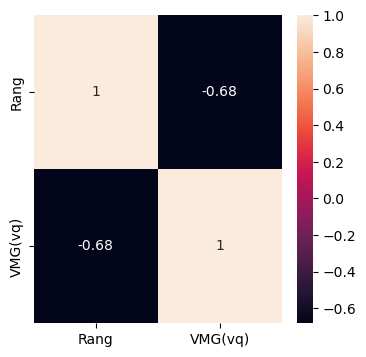

In [1341]:
fig = plt.figure(figsize=(4,4))
sns.heatmap(matrix, annot=True)
plt.show()

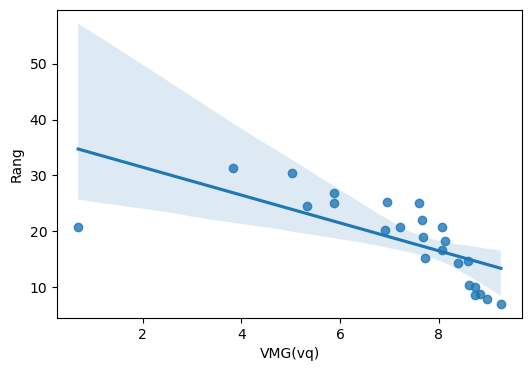

In [1342]:
## Regression linéaire

corr_data = corr_data.sort_values(by=['Rang'])
values = corr_data["Rang"].value_counts()

fig = plt.figure(figsize =(6,4))
sns.regplot(corr_data["VMG(vq)"],corr_data["Rang"])
plt.show()

### Réponses :
**On constate que plus la vitesse myenne VMG est élevée, plus le rang est faible , donc le Skipper est plus haut dans le classement.**

## **Impact de la présence d'un foil sur le classement et la vitesse des voiliers.**

In [1343]:
## Preprocessing des données de foil

data_foil = data_corr.copy()
for i, element in enumerate(data_foil['Nombre de dérives']) : 
    ind = np.array(data_foil['Nombre de dérives'].index)
    data_foil['Nombre de dérives'][ind[i]] = str(element).replace("foils","0").replace("foiler","0").replace("asymétriques","")#.replace("asymétriques","")
           
    if int(data_foil['Nombre de dérives'][ind[i]]) > 0:
        data_foil['Nombre de dérives'][ind[i]] = 0
    else :
        data_foil['Nombre de dérives'][ind[i]] = 1
        
data_foil['Nombre de dérives'] = data_foil['Nombre de dérives'].astype('int64')
print(data_foil['Nombre de dérives'].value_counts())
data_corr_with_foil = data_foil[['Rang', 'VMG(vq)', 'Nombre de dérives']].corr()
data_corr_with_foil

1    636
0    320
Name: Nombre de dérives, dtype: int64


,Rang,VMG(vq),Nombre de dérives
Rang,1.000000,-0.483499,-0.250416
VMG(vq),-0.483499,1.000000,0.067138
Nombre de dérives,-0.250416,0.067138,1.000000


### **Réponses :**

On peut conclure que la présence de foils est corrélée positivement avec la vitesse (VMG) et négativement avec le rang.
Cela rejoint précédemment car plus la vitesse est grande, plus le skipper est favoris dans les classements.

## **Visualisation de la distance parcourue par voilier.**

In [1344]:
## Visualisation de la distance parcourue par voilier
data_total = data_total.sort_values(by=['date'])

df_final = data_total.loc[(data_total["date"] >= "2021-01-27 00:00:00")]
df_final.head(5)

,index,Skipper,b_name,Numéro de voile,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,...,Cap(dc),Vitesse(dc),VMG(dc),Distance(dc),Cap(vq),Vitesse(vq),VMG(vq),Distance(vq),DTF,DTL
10055,2505,Manuel COUSIN,GROUPE SÉTIN,FRA 71,Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,"18,28 m","5,80 m","4,50 m",...,349.0,13.2,12.1,92.6,354.0,10.3,9.8,247.0,4647.2,4386.2
10056,7427,Miranda MERRON,CAMPAGNE DE FRANCE,FRA 50,Owen Clarke,"Southern Ocean Marine, Tauranga",04 Mai 2006,"18,28 m","5,50 m","4,50 m",...,353.0,11.1,10.5,77.9,0.0,9.6,9.4,230.0,4748.1,4487.1
10057,5941,Ari HUUSELA,STARK,FIN FRA 02FRA 02FRA 02,Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,"18,28 m","5,80 m","4,50 m",...,28.0,12.0,11.9,83.7,47.0,12.0,11.8,288.1,6491.2,6230.2
10054,2222,Didac COSTA,ONE PLANET ONE OCEAN,ESP 33,Owen Clarke Design,Martens Yachts,02 Février 2000,"18,28 m","5,30 m","4,50 m",...,6.0,13.4,13.0,93.9,6.0,13.0,12.6,312.4,3748.3,3487.3
10059,572,Yannick BESTAVEN,MAÎTRE COQ IV,FRA 17,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",...,84.0,19.6,19.4,136.9,81.0,18.9,18.9,453.0,443.9,182.8


In [1345]:
df_final_sorted = df_final.sort_values(by=['DTF'], ascending = False)

df_final_sorted = pd.concat([df_final_sorted["Skipper"],df_final_sorted["DTF"]],axis =1)#
df_final_sorted = df_final_sorted.groupby(['Skipper']).mean()
df_final_sorted = df_final_sorted.sort_values(by=['DTF'],ascending = True )
df_final.head(5)

,index,Skipper,b_name,Numéro de voile,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,...,Cap(dc),Vitesse(dc),VMG(dc),Distance(dc),Cap(vq),Vitesse(vq),VMG(vq),Distance(vq),DTF,DTL
10055,2505,Manuel COUSIN,GROUPE SÉTIN,FRA 71,Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,"18,28 m","5,80 m","4,50 m",...,349.0,13.2,12.1,92.6,354.0,10.3,9.8,247.0,4647.2,4386.2
10056,7427,Miranda MERRON,CAMPAGNE DE FRANCE,FRA 50,Owen Clarke,"Southern Ocean Marine, Tauranga",04 Mai 2006,"18,28 m","5,50 m","4,50 m",...,353.0,11.1,10.5,77.9,0.0,9.6,9.4,230.0,4748.1,4487.1
10057,5941,Ari HUUSELA,STARK,FIN FRA 02FRA 02FRA 02,Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,"18,28 m","5,80 m","4,50 m",...,28.0,12.0,11.9,83.7,47.0,12.0,11.8,288.1,6491.2,6230.2
10054,2222,Didac COSTA,ONE PLANET ONE OCEAN,ESP 33,Owen Clarke Design,Martens Yachts,02 Février 2000,"18,28 m","5,30 m","4,50 m",...,6.0,13.4,13.0,93.9,6.0,13.0,12.6,312.4,3748.3,3487.3
10059,572,Yannick BESTAVEN,MAÎTRE COQ IV,FRA 17,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",...,84.0,19.6,19.4,136.9,81.0,18.9,18.9,453.0,443.9,182.8


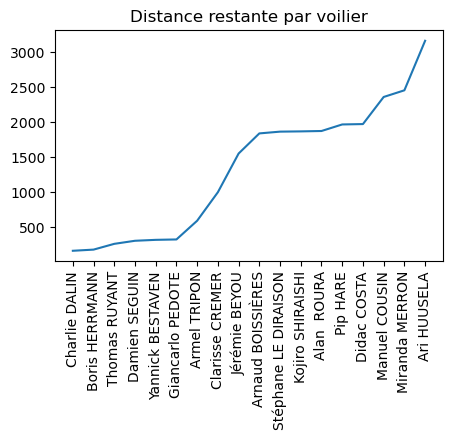

In [1347]:
fig = plt.figure(figsize = (5,3))

plt.plot(df_final_sorted["DTF"])
plt.xticks(rotation=90)
plt.title("Distance restante par voilier")
plt.show()

### **Commentaires :**

**Plus le minimum de distance restant à parcourir est faible, plus la distance parcourue est grande.**

## **Cartes avec les routes d'un ou plusieurs voiliers.**


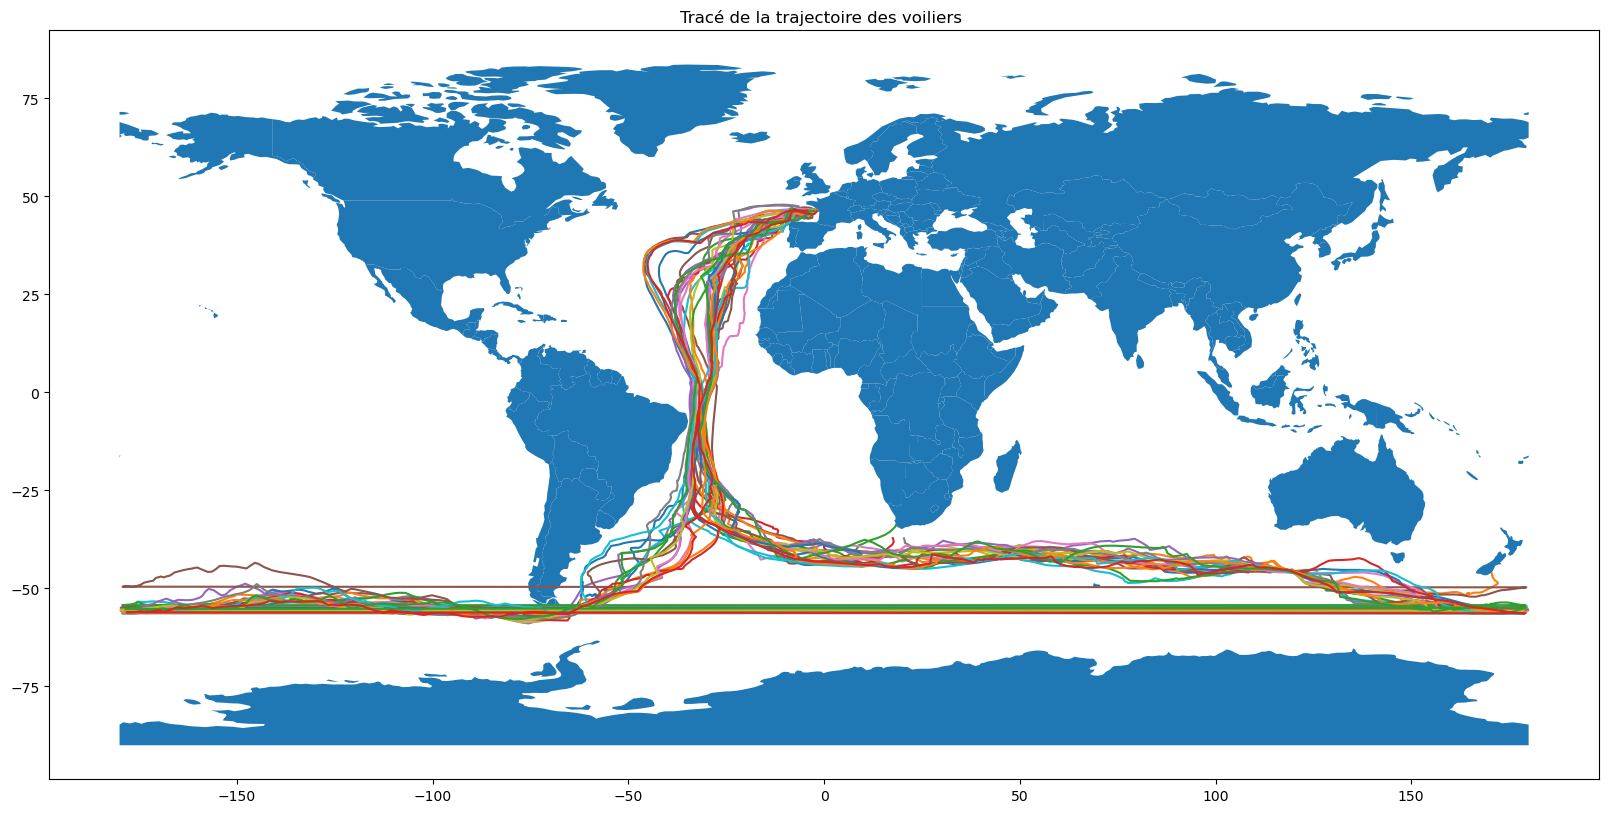

In [1348]:
fig, ax = plt.subplots(figsize=(20, 10))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax)

# Affichage des trajectoires
for b in data_total['b_name'].unique():
    tab = data_total.loc[(data_total['b_name'] == b)]
    plt.plot(tab['Longitude'], tab['Latitude'])
    plt.title("Tracé de la trajectoire des voiliers ")